# Amplify SDKを用いた人狼ゲームにおける役職推定

## はじめに

このドキュメントでは人狼というパーティーゲームをテーマにした最適化問題を取り扱っています。人狼の基本ルールをベースに話を進めていきますが基本ルールを知らない方は最初にこちらのサイトをご参照ください。   
[【はじめてのじんろう】人狼を全く知らない初心者のための簡単ルール・説明書](https://www.bodoge-intl.com/list/insapo/hazimete/)

人狼ゲームは他プレイヤーの役職が伏せられた状態で適切な行動を選択する必要があります。このプログラムでは全プレイヤーの行動履歴（以降ログとする）から論理的に推定できることやプレイヤー間の関係などを基に現段階で最も適切な役職推定を提供することを目指します。   

今回は対人において立ち回りがより複雑な多人数での人狼ゲームを想定し、15人対戦における役職推定を行います。   
役職配分は以下で定義しているように村人陣営11人（村人8人, 占い師1人, 霊媒師1人, 守護者1人）, 人狼陣営4人（人狼3人, 狂人1人）という構成とします。

In [ ]:
n_role = 6  # 役職数
n_player = 15  # プレイヤー数
n_villager = 8  # 村人の人数
n_seer = 1  # 占い師の人数
n_medium = 1  # 霊媒師の人数
n_guard = 1  # 守護者の人数
n_werewolf = 3  # 人狼の人数
n_possessed = 1  # 狂人の人数


## ログについて

初めにログを確認してみます。人狼知能国際大会ではAI同士の対戦ログを取得することができ, 今回はそれを用いることにします。   
ここではgameディレクトリにあるsample.logを試しに見てみます。

In [ ]:
# 必要に応じて実行してください
# !pip install pandas

In [ ]:
import pandas as pd

df = pd.read_csv("./game/sample.log")
print(df)


     day   class   a          b         c           d
0      0  status   1       SEER     ALIVE    tonkatsu
1      0  status   2  BODYGUARD     ALIVE        KP22
2      0  status   3   WEREWOLF     ALIVE     kgu_ryu
3      0  status   4   VILLAGER     ALIVE    sUper_IL
4      0  status   5   WEREWOLF     ALIVE      daphne
..   ...     ...  ..        ...       ...         ...
766    4  status  12   VILLAGER     ALIVE    takoyaki
767    4  status  13   VILLAGER     ALIVE  CanisLupus
768    4  status  14   VILLAGER     ALIVE         ioh
769    4  status  15   WEREWOLF      DEAD      Basket
770    4  result  12          0  VILLAGER         NaN

[771 rows x 6 columns]


ここでdayは人狼ゲームにおける日にち, classは情報の種類を表しています。他にも情報の種類にはstatus(プレイヤー番号, 役職および生存情報)の他にwhisper(人狼同士の会話で他プレイヤーに公開されない), talk（昼の話し合い内容）, vote（各プレイヤーの追放者投票）などがあります。   
特にログの大半はtalkで占められています。下のコードを実行することで1日目のtalk内容を確認することができます。

In [ ]:
df_day1 = df[df["day"] == 1]
print(df_day1[df_day1["class"] == "talk"])


     day class    a   b   c                            d
43     1  talk    0   0   6               VOTE Agent[01]
44     1  talk    1   0   8               VOTE Agent[01]
45     1  talk    2   0   3     COMINGOUT Agent[03] SEER
46     1  talk    3   0  14  ESTIMATE Agent[06] WEREWOLF
47     1  talk    4   0   5                         Skip
..   ...   ...  ...  ..  ..                          ...
233    1  talk  190  12   6                         Over
234    1  talk  191  12  11                         Over
235    1  talk  192  12   1                         Over
236    1  talk  193  12   7                         Over
237    1  talk  194  12  15                         Over

[195 rows x 6 columns]


ここでaはtalkのindex, bはターン数（1ターンで全員発言してから次のターンに移る）, cは発言者のプレイヤー番号, dは発言内容を表しています。   
特に発言内容については様々な種類があり主要なものとして   
- estimate（個人による他プレイヤーの役職推定）   
- comingout（主に役職持ちが自身の役職の公開に用いる, 人狼の騙りCOの可能性も）   
- divined（占い師（人狼の騙り含む）による占い結果報告, 対象指定メソッドの情報公開）   
- identified （霊媒師（人狼の騙り含む）による前ターン追放者の陣営公開)   
- guarded（護衛報告, 対象指定メソッドの情報公開）   
- vote（投票先の事前宣言）

があります。   

## 役職推定方針

今回は以上の内容で構成されているログを用い, 以下の3つの最適化を通じて役職推定を行うことにします。   

1. ログからプレイヤー同士の関係値や人狼としての怪しさを構築し, max-cut問題（グループ分け問題）として最適化を行うことで全プレイヤーから人狼を抽出する   

2. 人狼以外のプレイヤーの中でmax-cut問題を解くことで人狼以外のプレイヤーの中から狂人を抽出する   

3. ログから各プレイヤーが他プレイヤーをどの役職だと推測しているかを解釈し, 組み合わせ最適化問題として残った村人陣営中での役職推定を行う。   

### 1. について

全プレイヤーから人狼を3人抽出するmax-cut問題について考えます。   
プレイヤー同士の敵対度を表す15×15の2次元配列をhatredとし, 行動の人狼らしさ（怪しさ）を表す長さ15の1次元配列をwolf_likelyとします（ここでhatred, wolf_likelyの各要素は0~1の実数値をとることにします）。   
またここで最適化を行う長さ15の1次元バイナリ変数配列をwolf_divisionとすれば, max-cut問題の定式化に人狼としての怪しさを加味することで目的関数cost_wolfは以下のように構築することができます。

$$ cost\_wolf = \sum_{i} \sum_{j} hatred[i][j] \bigl(2wolf\_division[i]-1\bigr)\bigl(2wolf\_division[j]-1\bigr) - \sum_{i} wolf\_likely[i](2wolf\_division[i] -1) $$

>※一般的にmax-cut問題はIsing模型で表現されますが今回は各最適化で用いる変数種を統一するために目的関数は全てQUBO模型として構築されています。Ising模型で目的関数を構築すると以下のようになります。
>$$ cost\_wolf = \sum_{i} \sum_{j} hatred[i][j]s[i]s[j] 
- \sum_{i} wolf\_likely[i]s[i] $$


この目的関数を最小化することを目指すことにより人狼として怪しい行動をし, かつ多くのプレイヤーと敵対的な関係にあるプレイヤーが抽出できることになります。

In [ ]:
# 必要に応じて実行してください
# !pip install amplify

In [ ]:
from amplify import BinarySymbolGenerator

gen = BinarySymbolGenerator()
wolf_division = gen.array(n_player)

### 2. について

続いて人狼以外の12人のプレイヤーから狂人と考えられる人を抽出するmax-cut問題について考えます。   
狂人は人狼陣営に属しており人狼が勝利できるような行動をとる傾向にあるため, 全プレイヤーから人狼を抽出するmax-cut問題と同じ目的関数をとることで狂人を抽出することを目指します。   
ここでの最適化を行う長さ15の1次元バイナリ変数配列をpossessed_divisionとすれば, 目的関数cost_possessedは1. と同様に
$$ cost\_possessed = \sum_{i} \sum_{j} hatred[i][j] \bigl(2*possessed\_division[i]-1\bigr) * \bigl(2*possessed\_division[j]-1\bigr) - \sum_{i} wolf\_likely[i] * (2*possessed\_division[i] -1) $$
と定義することにします。

In [ ]:
possessed_division = gen.array(n_player)

### 3について

最後に村人陣営11人からそれぞれの役職を推定する最適化について定式化を目指します。   
ここで新たに各プレイヤーが他プレイヤーに対してある役職だと推定している度合いを6×15×15の3次元配列assumption_arrayに格納することを考えます。   
（各要素は0~1の実数値をとるとします。例えば, assumption_array[role_index][i][j]=1 のときプレイヤーiはプレイヤーjをrole_indexに対応する役職だと確信していることになります）   
また最適化を行う6×15の2次元バイナリ変数配列をrole_divisionとすると, 2乗誤差を考えることにより目的関数cost_roleは
$$ cost\_role = \sum_{role} \sum_{i} \sum_{j} \bigl(role\_division[role][j] - assumption\_array[role][i][j] \bigr) ^2 $$
と表すことができます。

In [ ]:
role_estimation = gen.array(n_role, n_player)

## ログの解釈

続いて実際のログから先程の役職推定方針にて定義した配列を構築することを考えます。   

### 辞書の定義
初めにログの解釈にあたり必要な辞書を定義します。必要に応じて参照する程度で問題ありません。

In [ ]:
# 役職に対応する役職インデックスを返す辞書
dic = {
    "VILLAGER": 0,
    "SEER": 1,
    "BODYGUARD": 2,
    "MEDIUM": 3,
    "WEREWOLF": 4,
    "POSSESSED": 5,
    "HUMAN": 0,
}

# 役職インデックスに対応する役職を返す辞書
dic2 = {
    0: "VILLAGER",
    1: "SEER",
    2: "BODYGUARD",
    3: "MEDIUM",
    4: "WEREWOLF",
    5: "POSSESSED",
}

# 陣営を分ける辞書
dic_camp = {
    "VILLAGER": 0,
    "SEER": 0,
    "BODYGUARD": 0,
    "MEDIUM": 0,
    "WEREWOLF": 1,
    "POSSESSED": 1,
    "HUMAN": 0,
}

# human/werewolfを分ける辞書
dic_wolf = {
    "VILLAGER": 0,
    "SEER": 0,
    "BODYGUARD": 0,
    "MEDIUM": 0,
    "WEREWOLF": 1,
    "POSSESSED": 0,
    "HUMAN": 0,
}


### ログから必要な情報を抽出する

続いてログから各プレイヤーの日ごとの生存情報を格納するstatus_list, 各日の各プレイヤーの投票対象を格納するvote_list, 襲撃されたプレイヤー情報を格納するattacked_list, 各プレイヤーの実際の役職を格納するtrue_role(辞書) / role_list(リスト), 確実の会話内容を格納するtalk_listを作成します。   
これらの情報は具体的に各プレイヤーの行動を解釈する際に用いられます。

In [ ]:
df_list = []
status_list_tmp = []
vote_list = []
attacked_list = []
role_list = [[0 for _ in range(n_player)] for _ in range(n_role)]
talk_list = []

# 日にち毎にdataframeを分割
day = 0
while True:
    if df[df["day"] == day].empty:
        break
    else:
        df_list.append(df[df["day"] == day])
        day += 1

# status_list作成
for i in range(day):
    status_list_tmp.append(df_list[i][df_list[i]["class"] == "status"].values)

status_list = [[1 for _ in range(n_player)] for _ in range(day)]

for i in range(day):
    for j in range(n_player):
        if status_list_tmp[i][j][4] == "DEAD":
            status_list[i][j] = 0

# vote_list作成（インデックス注意、0日目と最終日にvoteは存在しない）
for i in range(day):
    vote_list.append(df_list[i][df_list[i]["class"] == "vote"].values)

# attacked_list作成(インデックス注意、0日目と最終日にattackは存在しない)
for i in range(day):
    attacked_list.append(df_list[i][df_list[i]["class"] == "attack"].values)

# true_role, role_list作成
df_status_list = status_list_tmp[0]

true_role = {}
for i in range(len(df_status_list)):
    true_role[i] = df_status_list[i][3]

for i in range(len(status_list[0])):
    role_list[dic[df_status_list[i][3]]][df_status_list[i][2] - 1] = 1

# day1以降のdataframeについて不必要なclassおよびカラムを削除
for i in range(1, day - 1):
    df_list[i] = df_list[i][df_list[i]["class"] == "talk"]
    drop_col = ["day", "class", "a", "b"]
    talk_list.append(
        df_list[i]
        .drop(drop_col, axis=1)
        .rename(columns={"c": "playernum", "d": "action"})
    )

以上でログの解釈に必要な情報を抽出することができました。例えば実際にattacked_listを出力してみると

In [ ]:
print(attacked_list)

[array([], shape=(0, 6), dtype=object), array([[1, 'attack', 1, 'false', nan, nan]], dtype=object), array([[2, 'attack', 1, 'false', nan, nan]], dtype=object), array([], shape=(0, 6), dtype=object), array([], shape=(0, 6), dtype=object)]


何日目にどの番号のプレイヤーが襲撃されているかを確認することができます。  
>'true'の場合襲撃され死亡, 'false'の場合襲撃されたが守護者に守られ生存していることを表しています。

### 各プレイヤーの行動をどのように解釈するか

#### 会話内容の解釈について
初めにtalk_listに格納されている各日のプレイヤーの発言内容を解釈していくことを考えます。   
ログについての部分で説明した主要な発言内容について, 解釈の方法を以下で説明します。

>以下具体的に加算する値については局所探索によって精度がより高くなるように決定しています。詳細については冗長になってしまうため省略します。

##### voteについて
会話フェーズにおけるvoteはこの日の投票フェーズでの投票先宣言を表しているため, 発言者は発言先を人狼陣営だと認識していることになります。よってassumption_arrayの該当要素を加算します。   
また投票宣言は相手を敵対的に認識している表れだと考えられるため該当hatred要素についても加算します。

In [ ]:
# Agent[05]などのテキストからプレイヤー番号を取り出す関数
def agentnum(text):
    n = text[6] + text[7]
    return int(n)


def vote_declaration(a, talk_player, assumption_array, hatred):
    assumption_array[4][talk_player][agentnum(a[1]) - 1] += 0.2
    assumption_array[5][talk_player][agentnum(a[1]) - 1] += 0.2
    hatred[talk_player][agentnum(a[1]) - 1] += 0.1

##### comingoutについて
自身の役職をカミングアウトすることは発言者が自身をその役職だと確信していると換言することができます。そのためassumption_arrayの該当要素に1を加算します。   
>assumption_arrayは各日にちの最後に規格化されています。  
   
また他プレイヤーは発言者のCO役職及び偽物の可能性を意識することになるため, 各プレイヤーの発言者に対するCO役職/狂人/人狼だと認識する度合いについて加算します。

In [ ]:
def comingout(a, talk_player, assumption_array, CO_list):
    CO_list[talk_player] = dic[a[2]]
    assumption_array[dic[a[2]]][talk_player][talk_player] += 1
    for player in range(n_player):
        if player != talk_player:
            assumption_array[dic[a[2]]][player][talk_player] += 0.4
            assumption_array[4][player][talk_player] += 0.4
            assumption_array[5][player][talk_player] += 0.4


##### divined
占い結果報告は前日の段階での占い師のCO人数によって解釈が異なります。   


- 占い師のCO人数が前日の段階で2人以上のとき, 騙り占い師が偽の結果報告をしている可能性があるため自身及び発言者を占い師だと信用しているプレイヤーに対してassumption_arrayの該当要素を加算します。また真偽は定かではないですが占い結果に応じて占われたプレイヤーの人狼らしさを増減させます。
- 占い師のCO人数が前日の段階で1人のとき, 全員に対してassumption_arrayの情報更新を行います。また占い結果が人間の場合はそのプレイヤーが人狼でないことが確定し, 人狼の場合は逆に人狼であることが確定するためrole_estimation及びwolf_divisionに変数代入を行います。最後に変数代入された内容が自身の認識と矛盾していた（例：人狼だと認識していたプレイヤーの役職が人狼ではないことが判明した）場合についてはassumption_arrayの該当要素の修正を行います。   
>占い結果報告は役職COに翌日以降に行われます。

In [ ]:
# 指定された役職のCO人数を返す関数
def comingout_num(roleindex, assumption_array):
    count = 0
    for i in range(n_player):
        if assumption_array[roleindex][i][i] >= 1:
            count += 1
    return count


# 判明した真の役職について反対の陣営だと少しでも認識していたプレイヤーの該当要素を修正する関数
def change_recognition(assumption_array, role, playernum):
    if dic_camp[role] == 0:  # 追放者が村人陣営
        for role_index in range(4, 6):
            for i in range(n_player):
                # 人狼陣営だと思っていればその要素を0に更新
                if assumption_array[role_index][i][playernum] > 0:
                    assumption_array[role_index][i][playernum] = 0
    else:  # 追放者が人狼陣営
        for role_index in range(4):
            for i in range(n_player):
                # 村人陣営だと思っていればその要素を0に更新
                if assumption_array[role_index][i][playernum] > 0:
                    assumption_array[role_index][i][playernum] = 0


def divined(
    a, talk_player, assumption_array, wolf_likely, wolf_division, role_estimation
):
    # 発言者は自身を占い師だと認識
    assumption_array[1][talk_player][talk_player] += 1
    if comingout_num(1, assumption_array) >= 2:
        # 占い師COが複数人いる場合騙りの可能性があるため発言者および発言者を占い師だと思っているプレイヤーに関して情報更新を行う
        assumption_array[dic[a[2]]][talk_player][agentnum(a[1]) - 1] += 1
        for player in range(n_player):
            if (
                player != agentnum(a[1]) - 1
                and assumption_array[1][player][talk_player] >= 1
            ):
                assumption_array[dic[a[2]]][player][agentnum(a[1]) - 1] += 1

        # 真偽は分からないが少しだけ人狼らしさを加減する
        if dic_wolf[a[2]] == 0:
            wolf_likely[agentnum(a[1]) - 1] -= 0.1
        else:
            wolf_likely[agentnum(a[1]) - 1] += 0.5
    else:
        # 全員に対して情報更新を行う
        for player in range(n_player):
            if player != agentnum(a[1]) - 1:
                assumption_array[dic[a[2]]][player][agentnum(a[1]) - 1] += 1
        # role_estimationについて定数代入
        if dic[a[2]] == 0:
            role_estimation[4, agentnum(a[1]) - 1] = 0
        else:
            role_estimation[dic[a[2]], agentnum(a[1]) - 1] = 1
            wolf_division[agentnum(a[1]) - 1] = 1
            wolf_likely[agentnum(a[1]) - 1] = 1
        # 今までの情報と判明した占い先プレイヤーの陣営が矛盾する場合は更新
        change_recognition(assumption_array, a[2], agentnum(a[1]) - 1)
        # 占い師CO1人より変数代入
        wolf_division[agentnum(a[1]) - 1] = dic_wolf[a[2]]


##### estimate
この発言内容は他プレイヤーの役職推測に他ならないためassumption_arrayの該当要素を加算します。

In [ ]:
def estimate(a, talk_player, assumption_array):
    assumption_array[dic[a[2]]][talk_player][agentnum(a[1]) - 1] += 0.2


##### request
requestは基本的に他プレイヤーへの投票呼びかけに用いられます。そのためvoteと同様の情報更新を行います。

In [ ]:
def request(a, talk_player, assumption_array, hatred):
    if a[2] == "(VOTE":
        assumption_array[4][talk_player][agentnum(a[3]) - 1] += 0.2
        assumption_array[5][talk_player][agentnum(a[3]) - 1] += 0.2
        hatred[talk_player][agentnum(a[3]) - 1] += 0.1


##### identified
identifiedは霊媒師による追放者の霊媒結果報告ですが, ログの解釈について占い結果報告divined と変わりません。   
霊媒師のCO人数で場合分けをしてリストの要素更新, 変数代入を行います。

In [ ]:
def identified(
    a, talk_player, assumption_array, wolf_likely, wolf_division, role_estimation
):
    # 発言者は自身を霊媒師だと認識
    assumption_array[3][talk_player][talk_player] += 1
    if comingout_num(3, assumption_array) >= 2:
        # 霊媒師COが複数人いる場合騙りの可能性があるため発言者のみに関して情報更新を行う
        for player in range(n_player):
            if (
                player != agentnum(a[1]) - 1
                and assumption_array[3][player][talk_player] >= 1
            ):
                assumption_array[dic[a[2]]][player][agentnum(a[1]) - 1] += 1
        if a[2] == "HUMAN":
            for role in range(4):
                assumption_array[role][talk_player][
                    agentnum(a[1]) - 1
                ] += 0.3  # TODO: 要探索
            assumption_array[5][talk_player][agentnum(a[1]) - 1] += 0.3
        else:
            assumption_array[4][talk_player][agentnum(a[1]) - 1] += 0.3

        # 真偽は分からないが少しだけ人狼らしさを加減する
        if dic_wolf[a[2]] == 0:
            wolf_likely[agentnum(a[1]) - 1] -= 0.2
        else:
            wolf_likely[agentnum(a[1]) - 1] += 0.5
    else:
        # 霊媒師COが0もしくは1人のとき全員に対して情報更新を行う
        if a[2] == "HUMAN":
            # HUMANのときは狂人の可能性も含めてassumption_array加算
            for player in range(n_player):
                if player != agentnum(a[1]) - 1:
                    for role in range(4):
                        assumption_array[role][player][
                            agentnum(a[1]) - 1
                        ] += 0.6  # TODO: 要探索
                    assumption_array[5][player][agentnum(a[1]) - 1] += 0.6
            # 属性HUMANのとき人狼ではないのでsに定数代入
            role_estimation[4, agentnum(a[1]) - 1] = 0
        else:
            for player in range(n_player):
                if player != agentnum(a[1]) - 1:
                    assumption_array[4][player][agentnum(a[1]) - 1] += 1
            # 属性人狼のときsに定数代入
            role_estimation[4, agentnum(a[1]) - 1] = 1
            wolf_division[agentnum(a[1]) - 1] = 1 #FIXME: 変更した
            wolf_likely[agentnum(a[1]) - 1] = 1
        # 今までの情報と判明した追放者の陣営が矛盾する場合は更新
        change_recognition(assumption_array, a[2], agentnum(a[1]) - 1)

        # 霊媒師COが1人のため変数代入
        wolf_division[agentnum(a[1]) - 1] = dic_wolf[a[2]]


#### 話し合い終了後のCO人数に基づく分析
続いて話し合い終了後の各役職のCO人数によって制約条件の追加/変数代入を行います。   
- CO人数が2人以上のとき, COしたプレイヤーの中で人狼は1人以下（狂人が騙っている可能性もあるため） / 本物は1人のみ / 各プレイヤーの役職は本物か人狼陣営のいずれか という制約条件をそれぞれ加えます。またCOしているプレイヤーに対し人狼らしさを加算します（1度のみ）。
- CO人数が1人のみのとき, そのプレイヤーが本物だとして役職を確定します（実戦において偽物がCOしたとき本物もそのターンにCOすることを前提としています）。

In [ ]:
# 指定された役職のCOしたplayernumを返す関数
def comingout_index(roleindex, assumption_array):
    a = []
    for i in range(n_player):
        if assumption_array[roleindex][i][i] >= 1:
            a.append(i)
    return a


# 現段階でプレイヤーiの役職が確定しているか判定する関数
def determined(s, i):
    counter = -1
    for j in range(n_role):
        if s[j, i] == 1:
            counter = 1
    return counter


from amplify.constraint import equal_to, less_equal


def comingout_analysis(
    assumption_array,
    wolf_likely,
    wolf_division,
    possessed_division,
    role_estimation,
    CO_penalty_list,
    constraints_list1,
    constraints_list2,
):
    # CO人数がそのターン終了後に制約を満たしている場合は役職確定とし変数代入
    for j in range(n_role):
        if comingout_num(j, assumption_array) == 1:
            a = comingout_index(j, assumption_array)
            if len(a) != 0:
                if determined(role_estimation, a[0]) == 0:
                    if j != 4:
                        wolf_division[a[0]] = 0
                    else:
                        wolf_division[a[0]] = 1
                    role_estimation[j, a[0]] = 1
                    possessed_division[a[0]] = 0

    # CO人数が制約を超えている時は制約条件を加え、人狼らしさを追加（初回のみ）
    for j in range(1, 4):
        b = 0
        c = 0
        if comingout_num(j, assumption_array) > 1:
            a = comingout_index(j, assumption_array)
            for k in range(len(a)):
                b += wolf_division[a[k]]
                c += role_estimation[j, a[k]]
                if (a[k] in CO_penalty_list) == False:
                    wolf_likely[a[k]] += 0.5
                    CO_penalty_list.append(a[k])
            if b != 0:
                constraints_list1.append(lambda b=b: less_equal(b, 1))
            if c != 0:
                constraints_list2.append(lambda c=c: equal_to(c, 1))
            # COしている人は本物/人狼/狂人のいずれか
            for index in a:
                d = (
                    role_estimation[4, index]
                    + role_estimation[5, index]
                    + role_estimation[j, index]
                )
                constraints_list2.append(lambda d=d: equal_to(d, 1))


#### 襲撃され死亡したプレイヤーの分析
人狼に襲撃されて死亡したプレイヤーは少なくとも人狼ではありません。そのためwolf_division及びrole_estimationの死亡プレイヤー要素に変数代入を行います。   
また死亡したプレイヤーが役職COをしていた場合他のCOプレイヤーの人狼らしさを加算します（死亡プレイヤーが狂人の可能性があるため偽物だと確定できる訳ではありません）。

In [ ]:
# 襲撃されて死亡したプレイヤーはHUMAN（人狼ではない）確定、人狼らしさも減らす
def attacked(assumption_array, wolf_likely, wolf_division, role_estimation, CO_list):
    wolf_division[attacked_list[i][0][2] - 1] = 0
    wolf_likely[attacked_list[i][0][2] - 1] = -1
    role_estimation[4, attacked_list[i][0][2] - 1] = 0
    # 襲撃されて死亡したプレイヤーがCOしていてそれが複数人いるとき
    if (
        CO_list[attacked_list[i][0][2] - 1] != -1
        and comingout_num(CO_list[attacked_list[i][0][2] - 1], assumption_array) > 1
    ):
        a = comingout_index(CO_list[attacked_list[i][0][2] - 1], assumption_array)
        for j in range(len(a)):
            if a[j] != attacked_list[i][0][2] - 1:
                wolf_likely[a[j]] = 1


#### 投票フェーズ
投票フェーズで各プレイヤーは投票対象を現段階で最も排除したいプレイヤーだと認識していることになります。   
そのためmax-cut問題における重みhatredの該当要素を1（最も敵対的）とします。

In [ ]:
# 生存人数を返す関数
def num_alive(status_list, day):
    count = 0
    for i in range(n_player):
        count += status_list[day][i]
    return count


def vote(day, hatred, status_list):
    if day != 1:
        for j in range(num_alive(status_list, day)):
            hatred[vote_list[day - 1][j][2] - 1][int(vote_list[day - 1][j][3]) - 1] = 1


### 具体的なログの解釈

それでは以上で定義した関数を用いて実際にログの解釈を行ってみましょう。   
初めに以下でログの解釈で必要になる関数を定義します。   
それぞれの関数の初めに関数の説明をコメントで入れているので適宜参照してください（一度実行さえすれば詳細に理解する必要はありません）。

In [ ]:
# assumption_arrayの生存者に対する要素をn倍する関数
def time_alive_3(assumption_array, n, day, status_array):
    for role in range(n_role):
        for i in range(n_player):
            for j in range(n_player):
                if i != j and status_array[day][j] == 1 and status_array[day][i] == 1:
                    assumption_array[role][i][j] *= n
    return assumption_array


# hatredの生存者に対する要素をn倍する関数
def time_alive_2(hatred, n, day, status_array):
    for i in range(n_player):
        for j in range(n_player):
            if status_array[day][j] == 1 and status_array[day][i] == 1:
                hatred[i][j] *= n
    return hatred


# wolf_hの生存者に対する要素をn倍する関数
def time_alive_1(wolf_h, n, day, status_array):
    for i in range(n_player):
        if status_array[day][i] == 1:
            wolf_h[i] *= n
    return wolf_h


# 値が1より大きくなっている要素について値を1に更新する（値が1より大きくなると目的関数の観点で逆効果のため）
def adjust(assumption_array):
    for role in range(n_role):
        for i in range(n_player):
            for j in range(n_player):
                if assumption_array[role][i][j] > 1:
                    assumption_array[role][i][j] = 1
    return assumption_array


# 2次元配列の要素の最大の絶対値を返す関数
def max_abs_list_2(list):
    tmp = 0
    for i in range(len(list)):
        for j in range(len(list[0])):
            if abs(list[i][j]) > tmp:
                tmp = abs(list[i][j])
    return tmp


# 2次元配列を規格化する関数
def standardize_list_2(list):
    a = float(max_abs_list_2(list))
    if a == 0:
        return list
    for i in range(len(list)):
        for j in range(len(list[0])):
            list[i][j] = float(list[i][j]) / a
    return list


下のコードを実行することで実際にログを解釈し, assumption_array / hatred / wolf_likekyの構築を行うことができます。

In [ ]:
# ログ解釈中にmax-cut問題/assumption_arrayの制約条件を加えるリスト
constraints_list_wolf = []
constraints_list_role = []

# 敵対値, 要素が0のとき中立
hatred = [[0 for _ in range(n_player)] for _ in range(n_player)]
hatred_list = [[[0 for _ in range(n_player)] for _ in range(n_player)]]

# 行動から読み取れる人狼らしさ
wolf_likely = [0 for _ in range(n_player)]
wolf_likely_list = [[0 for _ in range(n_player)]]

# それぞれのプレイヤーが他プレイヤーに対してこの役職だと認識している度合い
assumption_array_list = [
    [[[0 for _ in range(n_player)] for _ in range(n_player)] for _ in range(n_role)]
]
assumption_array = [
    [[0 for _ in range(n_player)] for _ in range(n_player)] for _ in range(n_role)
]

# 複数人COによるペナルティを受けたプレイヤーを格納するリスト
CO_penalty_list = []

# COした役職を格納するリスト
CO_list = [-1 for _ in range(n_player)]

for i in range(1, day - 1):
    hatred = time_alive_2(hatred, 0.5, i, status_list)
    wolf_likely = time_alive_1(wolf_likely, 1, i, status_list)
    assumption_array = time_alive_3(assumption_array, 0, i, status_list)

    vote(i, hatred, status_list)

    talk_list_day = talk_list[i - 1].values
    for j in range(len(talk_list_day)):
        if talk_list_day[j][1] == "Over" or talk_list_day[j][1] == "Skip":
            continue
        else:
            a = talk_list_day[j][1].split()
            if a[0] == "VOTE":
                vote_declaration(
                    a, int(talk_list_day[j][0]) - 1, assumption_array, hatred
                )
            elif a[0] == "COMINGOUT":
                comingout(a, int(talk_list_day[j][0]) - 1, assumption_array, CO_list)
            elif a[0] == "DIVINED":
                divined(
                    a,
                    int(talk_list_day[j][0]) - 1,
                    assumption_array,
                    wolf_likely,
                    wolf_division,
                    role_estimation,
                )
            elif a[0] == "ESTIMATE":
                estimate(a, int(talk_list_day[j][0]) - 1, assumption_array)
            elif a[0] == "REQUEST":
                request(a, int(talk_list_day[j][0]) - 1, assumption_array, hatred)
            elif a[0] == "IDENTIFIED":
                identified(
                    a,
                    int(talk_list_day[j][0]) - 1,
                    assumption_array,
                    wolf_likely,
                    wolf_division,
                    role_estimation,
                )

    comingout_analysis(
        assumption_array,
        wolf_likely,
        wolf_division,
        possessed_division,
        role_estimation,
        CO_penalty_list,
        constraints_list_wolf,
        constraints_list_role,
    )

    if (
        i < day - 2
        and len(attacked_list[i][0]) != 0
        and attacked_list[i][0][3] == "true"
    ):
        attacked(assumption_array, wolf_likely, wolf_division, role_estimation, CO_list)

    adjust(assumption_array)
    assumption_array_list.append(assumption_array)

    wolf_likely_list.append(wolf_likely)

    hatred = standardize_list_2(hatred)
    hatred_list.append(hatred)


以上でログの解釈を必要なリストに落とし込むことができました。それぞれのリストは日にち毎にそれぞれassumption_array_list, hatred_list, wolf_likely_listに格納されています。   

## 最適化

### 1. 人狼検出のmax-cut問題における最適化

初めにこの最適化で用いる関数を定義します。コメントで各関数の説明をしているので適宜参照してください（一度実行さえすれば詳細に確認する必要はありません）。

In [ ]:
# 1次元配列の要素の最大の絶対値を返す関数
def max_abs_list(list):
    tmp = 0
    for i in range(len(list)):
        if abs(list[i]) > tmp:
            tmp = abs(list[i])
    return tmp


# 1次元配列を規格化する関数
def standardize_list(list):
    a = float(max_abs_list(list))
    if a == 0:
        return list
    for i in range(len(list)):
        list[i] = float(list[i]) / a
    return list


# 最適化前に変数代入で答えが分かっているかどうか判定する関数
def all_inserted(wolf_division):
    flag = 1
    for i in range(n_player):
        if wolf_division[i] == 0 or wolf_division[i] == 1:
            continue
        else:
            flag = 0
    return flag


#### 最適化
1. 目的関数について   
役職推定方針で説明した目的関数を再掲します。   
$$ cost\_wolf = \sum_{i} \sum_{j} hatred[i][j] \bigl(2*wolf\_division[i]-1\bigr) * \bigl(2*wolf\_division[j]-1\bigr) - \sum_{i} wolf\_likely[i] * (2*wolf\_division[i] -1) $$
この目的関数はAmplifyで提供されている定式化補助関数sum_polyを利用することで簡潔に表現することが可能です。   


2. 制約条件について   
人狼抽出のmax-cut問題ではログの解釈時に得られた制約条件の他に人狼が3人であるという制約条件が加わります。

以上の内容を踏まえて実際に最適化を行い, その結果を出力してみましょう。

In [ ]:
from amplify import sum_poly, Solver
from amplify.client import FixstarsClient

# 人狼らしさの目的関数における重み
weight = 1

# 制約条件の重みは最適化で共通
penalty = 15

# 規格化
wolf_likely_list[day - 2] = standardize_list(wolf_likely_list[day - 2])

# max-cut問題の目的関数
cost_wolf = sum_poly(
    n_player,
    lambda i: sum_poly(
        n_player,
        lambda j: hatred_list[day - 2][i][j]
        * (2 * wolf_division[i] - 1)
        * (2 * wolf_division[j] - 1),
    ),
) - sum_poly(
    n_player, lambda i: wolf_likely_list[day - 2][i] * (2 * wolf_division[i] - 1)
)

# ログから得られる制約条件
log_constraints_wolf = []
for f in constraints_list_wolf:
    log_constraints_wolf.append(f())

# 人狼は3人だけ
wolf_constraints = equal_to(wolf_division.sum(), n_werewolf)

constraints = sum(log_constraints_wolf) + wolf_constraints

model_wolf = cost_wolf + penalty * constraints

client = FixstarsClient()
client.parameters.timeout = 6000
client.token = "dRUQFpWYe2yGaq79bz9wmA8WNM2L3ZX9"
client.parameters.outputs.duplicate = True
solver = Solver(client)

if all_inserted(wolf_division) == 1:
    wolf_values = wolf_division
else:
    result_wolf = solver.solve(model_wolf)
    if len(result_wolf.solutions) == 0:
        raise RuntimeError("Any one of constraints is not satisfied.")

    energy = result_wolf.solutions[0].energy
    values = result_wolf.solutions[0].values
    wolf_values = wolf_division.decode(values)

print("optimization result:", wolf_values)
print("answer:             ", role_list[4])


optimization result: [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
answer:              [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


最適化結果と実際の人狼を比較してみると今回のログでは全員正しく抽出できていることが分かります。   
また100個のログを用いて精度判定を行ったところ人狼検出期待値は3人中2.75人となり, 高い精度が確認されました。

### 2. 狂人検出のmax-cut問題における最適化

狂人検出のmax-cut問題は人狼検出のmax-cut問題と目的関数は同一です。またログの解釈で得られた制約条件に加え狂人が一人のみという制約条件が加わります。   
このmax-cut問題で先ほど抽出された人狼3人について除外する必要があり, 目的関数に含まれるhatred, wolf_likely要素を0埋めします。   
これらをコード化した上で最適化を実行し, 結果を確認してみます。

In [ ]:
wolf_index = []

# 前のmax-cutで人狼と推定されたプレイヤーindexを取得
for i in range(n_player):
    if wolf_values[i] == 1:
        wolf_index.append(i)

# 人狼と判定されたプレイヤーの該当hatred/wolf_hを0埋めする
for w in wolf_index:
    for i in range(n_player):
        hatred_list[day - 2][w][i] = 0
        hatred_list[day - 2][i][w] = 0
    wolf_likely_list[day - 2][w] = 0

# 目的関数構築
cost_possessed = sum_poly(
    n_player,
    lambda i: sum_poly(
        n_player,
        lambda j: hatred_list[day - 2][i][j]
        * (2 * possessed_division[i] - 1)
        * (2 * possessed_division[j] - 1),
    ),
) - sum_poly(
    n_player, lambda i: wolf_likely_list[day - 2][i] * (2 * possessed_division[i] - 1)
)

# 狂人は１人のみ
possessed_constraints = equal_to(possessed_division.sum(), n_possessed)

model_possessed = cost_possessed + penalty * possessed_constraints
result_possessed = solver.solve(model_possessed)
if len(result_possessed.solutions) == 0:
    raise RuntimeError("Any one of constraints is not satisfied.")

energy2 = result_possessed.solutions[0].energy
values2 = result_possessed.solutions[0].values
possessed_values = possessed_division.decode(values2)

print("optimization result:", possessed_values)
print("answer:             ", role_list[5])


optimization result: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
answer:              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


最適化結果を確認してみると狂人が正しく検出できていないことがわかります。   
100個のログで狂人検出率を確認したところ23％と低く留まってしまう結果となりました。しかし, max-cut問題による最適化をせずにassumption_array（各プレイヤーの認識）のみで役職推定を行った際の狂人検出率を求めたところ7％であったことから, 検出精度の向上は認められました。   
狂人検出精度が低く留まった原因としては以下が考えらます。   
- 狂人は占いや霊媒結果が村人扱いとなってしまうため行動の特徴から村人との差別化を図る必要がある
- 狂人は人狼プレイヤーを把握していないため人狼の勝利を目指す行動が取りずらい
- 人狼AIは狂人として場を混乱させる行動を取るのではなく, 自身が吊られないように周りと同調する行動を取る傾向がありグループ分けにおいて村人側に振り分けられやすい

### 3. 村人陣営中の役職推定における組み合わせ最適化

初めにこの最適化で用いる関数を定義します。

In [ ]:
# すでに狂人と確定したプレイヤーがいるか判定する関数
def determined_possessed(s):
    counter = -1
    for j in range(n_player):
        if s[5, j] == 1:
            counter = 1
    return counter


#### 最適化
検出された人狼, 狂人をrole_estimationに反映させた上で村人陣営の役職推定を行います。
1. 目的関数について   
役職推定方針で説明した目的関数を再掲します。   
$$ cost\_role = \sum_{role} \sum_{i} \sum_{j} \bigl(role\_division[role][j] - assumption\_array[role][i][j] \bigr) ^2 $$
この目的関数についてもAmplifyで提供されている定式化補助関数sum_polyを利用することで簡潔に表現することが可能です。  

2. 制約条件について   
この最適化特有の制約条件として   
- 各役職の人数が決まっている
- 各プレイヤーには一つの役職が割り当てられる      
があります。  

下のコードを実行することで最終的な全プレイヤーの役職推定を得ることができます。

In [ ]:
from amplify.constraint import one_hot
import numpy as np

possessed_index = -1

# max-cutの結果を反映
for i in range(n_player):
    if wolf_values[i] == 1:
        if determined(role_estimation, i) == -1:
            role_estimation[4, i] = 1
    if possessed_values[i] == 1:
        if (
            determined(role_estimation, i) == -1
            and determined_possessed(role_estimation) == -1
        ):
            role_estimation[5, i] = 1
            possessed_index = i

assumption_array_list = np.array(assumption_array_list)
role_list = np.array(role_list)

# 2乗誤差で目的関数を作成
cost_role = sum_poly(
    n_role,
    lambda role: sum_poly(
        n_player,
        lambda i: sum_poly(
            n_player,
            lambda j: (
                role_estimation[role, j] - assumption_array_list[day - 2, role, i, j]
            )
            ** 2,
        ),
    ),
)

# プレイヤー1人に1つの役職が割り当てられることに起因する制約
player_constraints = []
for i in range(n_player):
    player_constraints.append(one_hot(role_estimation[:, i].sum()))

# ログから得られる制約条件
log_constraints_role = []
for f in constraints_list_role:
    log_constraints_role.append(f())

# 役職ごとに人数が決まっていることに起因する制約
role_constraints = sum(
    equal_to(role_estimation[0].sum(), n_villager)
    + equal_to(role_estimation[1].sum(), n_seer)
    + equal_to(role_estimation[2].sum(), n_guard)
    + equal_to(role_estimation[3].sum(), n_medium)
    + equal_to(role_estimation[4].sum(), n_werewolf)
    + equal_to(role_estimation[5].sum(), n_possessed)
)

constraints_role = (
    sum(log_constraints_role) + sum(player_constraints) + role_constraints
)

model_role = cost_role + penalty * constraints_role
result_role = solver.solve(model_role)

if len(result_role.solutions) == 0:
    # 狂人と特定したプレイヤーによっては制約条件と嚙み合わず答えが得られない場合がある（狂人特定率の低さ故）
    # 狂人特定が矛盾をもたらしたとき狂人は別のプレイヤーだとして最適化を行う（1回目のmax-cutの結果のみを利用し、村人陣営から役職推定を行う）
    role_estimation[5, possessed_index] = 0

    cost_role = sum_poly(
        n_role,
        lambda role: sum_poly(
            n_player,
            lambda i: sum_poly(
                n_player,
                lambda j: (
                    role_estimation[role, j]
                    - assumption_array_list[day - 2, role, i, j]
                )
                ** 2,
            ),
        ),
    )

    player_constraints = []
    for i in range(n_player):
        player_constraints.append(one_hot(role_estimation[:, i].sum()))

    log_constraints_role = []
    for f in constraints_list_role:
        log_constraints_role.append(f())

    role_constraints = sum(
        equal_to(role_estimation[0].sum(), n_villager)
        + equal_to(role_estimation[1].sum(), n_seer)
        + equal_to(role_estimation[2].sum(), n_guard)
        + equal_to(role_estimation[3].sum(), n_medium)
        + equal_to(role_estimation[4].sum(), n_werewolf)
        + equal_to(role_estimation[5].sum(), n_possessed)
    )

    constraints_role = (
        sum(log_constraints_role) + sum(player_constraints) + role_constraints
    )

    model_role = cost_role + penalty * constraints_role
    result_role = solver.solve(model_role)

    if len(result_role.solutions) == 0:
        raise RuntimeError("Any one of constraints is not satisfied.")

energy3 = result_role.solutions[0].energy
values3 = result_role.solutions[0].values
role_values = role_estimation.decode(values3)

print("optimization result:", *role_values, sep="\n ")
print("answer:             ", *role_list, sep="\n ")


optimization result:
 [0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
answer:             
 [0 0 0 1 0 1 1 0 0 1 1 1 1 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


最終的な各プレイヤーの役職推定が6×15の2次元配列で出力されています。真の役職と最適化結果の乖離を以下で評価してみます。   

In [ ]:
# role_arrayとestimated_role_arrayの乖離の評価
wolfcamp_identification = 0
seer_identification = 0
medium_identification = 0
guard_identification = 0
total_identification = 0
for i in range(n_role):
    for j in range(n_player):
        if i == 1:
            seer_identification += int(role_values[i, j]) * role_list[i][j]
        elif i == 2:
            guard_identification += int(role_values[i, j]) * role_list[i][j]
        elif i == 3:
            medium_identification += int(role_values[i, j]) * role_list[i][j]
        elif i == 4:
            wolfcamp_identification += int(role_values[i, j]) * role_list[i][j]
            wolfcamp_identification += int(role_values[i, j]) * role_list[i + 1][j]
        elif i == 5:
            wolfcamp_identification += int(role_values[i, j]) * role_list[i][j]
            wolfcamp_identification += int(role_values[i, j]) * role_list[i - 1][j]
        total_identification += int(role_values[i, j]) * role_list[i][j]

print(wolfcamp_identification, "/ 4 players are correctly identified as wolf_camp")
if seer_identification == 1:
    print("seer is correctly identified")
else:
    print("seer is incorrectly identified")
if guard_identification == 1:
    print("bodyguard is correctly identified")
else:
    print("bodyguard is incorrectly identified")
if medium_identification == 1:
    print("medium is correctly identified")
else:
    print("medium is incorrectly identified")
print(
    "totally", total_identification, "/ 15 players are correctly identified their roles"
)


3 / 4 players are correctly identified as wolf_camp
seer is correctly identified
bodyguard is correctly identified
medium is correctly identified
totally 13 / 15 players are correctly identified their roles


概ね正しく役職推定ができていることが確認できます。   
また全体の役職推定の精度判定を100個のログを用いて行った結果を以下に示します。

|正解人数|ログ数|
|--|--|
|8|1|
|9|3|
|10|16|
|11|46|
|12|6|
|13|25|
|15|3|

（期待値11.5人）

### プレイヤーの相関関係グラフの可視化

本問題ではプレイヤー同士の敵対度から人狼と狂人を抽出することでより精度の高い役職推定を実現しました。   
では実際に相関関係はどのようになっているでしょうか。   
networkxモジュールを用いることによってmax-cut問題におけるプレイヤー同士の敵対関係無向グラフとして可視化してみます。

In [ ]:
# 必要に応じて実行してください
# !pip install networkx matplotlib

assumption graph:


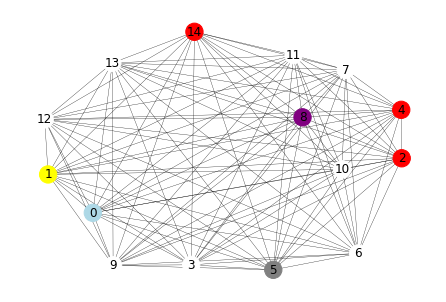

answer:
 {0: 'SEER', 1: 'BODYGUARD', 2: 'WEREWOLF', 3: 'VILLAGER', 4: 'WEREWOLF', 5: 'VILLAGER', 6: 'VILLAGER', 7: 'POSSESSED', 8: 'MEDIUM', 9: 'VILLAGER', 10: 'VILLAGER', 11: 'VILLAGER', 12: 'VILLAGER', 13: 'VILLAGER', 14: 'WEREWOLF'}


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.complete_graph(n_player)
for (u, v) in G.edges():
    G.edges[(u, v)]["weight"] = hatred_list[day-2][u][v]

assumption_role = {}
for i in range(n_player):
    for j in range(n_role):
        if role_values[j][i] == 1:
            assumption_role[i] = dic2[j]

color_map = []
for node in G:
    if assumption_role[node] == "WEREWOLF":
        color_map.append("red")
    elif assumption_role[node] == "POSSESSED":
        color_map.append("gray")
    elif assumption_role[node] == "SEER":
        color_map.append("lightblue")
    elif assumption_role[node] == "MEDIUM":
        color_map.append("purple")
    elif assumption_role[node] == "BODYGUARD":
        color_map.append("yellow")
    else:
        color_map.append("white")

nx.draw(G, node_color=color_map, with_labels=True, width=0.3)
print("assumption graph:")
plt.show()
print("answer:\n", true_role)

無向グラフが出力されました。   
それぞれのノードは推定結果に基づき色付けされており, 赤が人狼, 灰色が狂人, 黄色が守護者, 水色が占い師, 紫色が霊媒師に該当します。   
この無向グラフを見ると推定された人狼と狂人は他のプレイヤーと離れた位置にいる傾向が認められますが, 実際の狂人は7番であり村人と固まった位置にあることが分かります。この点からも狂人判定の難しさが読み取れます。

## 実戦における可能性

今までの最適化は15人のログを基に俯瞰視点で各プレイヤーの役職推定を行っていました。しかし対人ゲームでは自身の役職が分かった状態で会話をして他プレイヤーの役職を予想していく必要があります。   
以下では対人ゲームにおいて当事者視点での役職推定を提供することで自身の勝率を高める行動を促進するデモアプリとしての可能性について考察します。

### 俯瞰視点から当事者視点へ変わることによる方針の変化

俯瞰視点から当事者視点へ変わることで生じる方針の変化としては以下の3点があります。   
- バイナリ変数配列に当事者の情報を変数代入することができる
- max-cut問題において当事者を排除して考える必要がある
- 当事者が人狼ではないことを前提とする（人狼は他人狼を把握しており騙りCOにより特殊役職持ちについても容易に知ることができるため役職推定を利用するメリットが少ない）

>当事者が占い師などの特殊役職のとき騙りCOを偽物だと即座に判断することができますが, これは当事者情報さえ変数代入されていれば既存のコードで対応することが可能です。

### 当事者情報取得
デモアプリを想定し当事者情報をプルダウンにより取得できるようにします。   
今回用いているログにおいてプレイヤー1は占い師なので, プレイヤー1が初日の段階で人狼の可能性が高いプレイヤーを取得し占い対象として選択したい状況を想定してみます。   
下のコードを実行しプルダウンが表示されたらプレイヤー番号を1, 分析日を1と選択してください。

In [ ]:
from ipywidgets import Dropdown, interact

option_player_list = []
for i in range(n_player):
    option_player_list.append((i+1, i))
number_select = Dropdown(
    options=option_player_list,
    description="番号:",
)

option_day_list = []
for i in range(day-2):
    option_day_list.append((i+1, i+1))
day_select = Dropdown(
    options=option_day_list,
    description="分析日:",
)

playernum = -1
roleindex = -1
day_optimize = -1

@interact(number_select=number_select)
def get_playernum(number_select):
    global playernum
    playernum = number_select
    global roleindex
    roleindex = dic[true_role[playernum]]


@interact(day_select=day_select)
def get_day_optimize(day_select):
    global day_optimize
    day_optimize = day_select


interactive(children=(Dropdown(description='番号:', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

interactive(children=(Dropdown(description='分析日:', options=((1, 1), (2, 2), (3, 3)), value=1), Output()), _dom…

### 最適化
それでは実際に当事者視点での最適化を実行してみましょう。俯瞰視点でのプログラムから変更した部分にコメントを付しているので適宜参照してください。   

In [ ]:
wolf_division2 = gen.array(n_player)
# 当事者情報代入
wolf_division2[playernum] = 0

possessed_division2 = gen.array(n_player)
# 当事者情報代入
possessed_division2[playernum] = 0

role_estimation2 = gen.array(n_role, n_player)
# 当事者情報代入
role_estimation2[roleindex, playernum] = 1

constraints_list_wolf = []
constraints_list_role = []

hatred = [[0 for _ in range(n_player)] for _ in range(n_player)]
hatred_list = [[[0 for _ in range(n_player)] for _ in range(n_player)]]

wolf_likely = [0 for _ in range(n_player)]
wolf_likely_list = [[0 for _ in range(n_player)]]

assumption_array_list = [
    [[[0 for _ in range(n_player)] for _ in range(n_player)] for _ in range(n_role)]
]
assumption_array = [
    [[0 for _ in range(n_player)] for _ in range(n_player)] for _ in range(n_role)
]

CO_penalty_list = []

CO_list = [-1 for _ in range(n_player)]

for i in range(1, day_optimize + 1):
    hatred = time_alive_2(hatred, 0.5, i, status_list)
    wolf_likely = time_alive_1(wolf_likely, 1, i, status_list)
    assumption_array = time_alive_3(assumption_array, 0, i, status_list)

    vote(i, hatred, status_list)

    talk_list_day = talk_list[i - 1].values
    for j in range(len(talk_list_day)):
        if talk_list_day[j][1] == "Over" or talk_list_day[j][1] == "Skip":
            continue
        else:
            a = talk_list_day[j][1].split()
            if a[0] == "VOTE":
                vote_declaration(
                    a, int(talk_list_day[j][0]) - 1, assumption_array, hatred
                )
            elif a[0] == "COMINGOUT":
                comingout(a, int(talk_list_day[j][0]) - 1, assumption_array, CO_list)
            elif a[0] == "DIVINED":
                divined(
                    a,
                    int(talk_list_day[j][0]) - 1,
                    assumption_array,
                    wolf_likely,
                    wolf_division2,
                    role_estimation2,
                )
            elif a[0] == "ESTIMATE":
                estimate(a, int(talk_list_day[j][0]) - 1, assumption_array)
            elif a[0] == "REQUEST":
                request(a, int(talk_list_day[j][0]) - 1, assumption_array, hatred)
            elif a[0] == "IDENTIFIED":
                identified(
                    a,
                    int(talk_list_day[j][0]) - 1,
                    assumption_array,
                    wolf_likely,
                    wolf_division2,
                    role_estimation2,
                )

    comingout_analysis(
        assumption_array,
        wolf_likely,
        wolf_division2,
        possessed_division2,
        role_estimation2,
        CO_penalty_list,
        constraints_list_wolf,
        constraints_list_role,
    )

    if (
        i < day - 2
        and len(attacked_list[i][0]) != 0
        and attacked_list[i][0][3] == "true"
    ):
        attacked(
            assumption_array, wolf_likely, wolf_division2, role_estimation2, CO_list
        )

    adjust(assumption_array)
    assumption_array_list.append(assumption_array)

    wolf_likely_list.append(wolf_likely)

    hatred = standardize_list_2(hatred)
    hatred_list.append(hatred)


# 1回目の最適化
wolf_likely_list[day_optimize] = standardize_list(wolf_likely_list[day_optimize])

# 当事者をmax-cutから除外するために当事者の該当hatred/wolf_hを0埋めする
for i in range(n_player):
    hatred_list[day_optimize][playernum][i] = 0
    hatred_list[day_optimize][i][playernum] = 0
wolf_likely_list[day_optimize][playernum] = 0

cost_wolf = sum_poly(
    n_player,
    lambda i: sum_poly(
        n_player,
        lambda j: hatred_list[day_optimize][i][j]
        * (2 * wolf_division2[i] - 1)
        * (2 * wolf_division2[j] - 1),
    ),
) - sum_poly(
    n_player, lambda i: wolf_likely_list[day_optimize][i] * (2 * wolf_division2[i] - 1)
)

log_constraints_wolf = []
for f in constraints_list_wolf:
    log_constraints_wolf.append(f())

wolf_constraints = equal_to(wolf_division2.sum(), n_werewolf)

constraints = sum(log_constraints_wolf) + wolf_constraints

model_wolf = cost_wolf + penalty * constraints

client = FixstarsClient()
client.parameters.timeout = 6000
client.token = "dRUQFpWYe2yGaq79bz9wmA8WNM2L3ZX9"
client.parameters.outputs.duplicate = True
solver = Solver(client)

if all_inserted(wolf_division2) == 1:
    wolf_values = wolf_division2
else:
    result_wolf = solver.solve(model_wolf)
    if len(result_wolf.solutions) == 0:
        raise RuntimeError("Any one of constraints is not satisfied.")

    energy = result_wolf.solutions[0].energy
    values = result_wolf.solutions[0].values
    wolf_values = wolf_division2.decode(values)


# 2回目の最適化
wolf_index = []

for i in range(n_player):
    if wolf_values[i] == 1:
        wolf_index.append(i)

for w in wolf_index:
    for i in range(n_player):
        hatred_list[day_optimize][w][i] = 0
        hatred_list[day_optimize][i][w] = 0
    wolf_likely_list[day_optimize][w] = 0

cost_possessed = sum_poly(
    n_player,
    lambda i: sum_poly(
        n_player,
        lambda j: hatred_list[day_optimize][i][j]
        * (2 * possessed_division2[i] - 1)
        * (2 * possessed_division2[j] - 1),
    ),
) - sum_poly(
    n_player,
    lambda i: wolf_likely_list[day_optimize][i] * (2 * possessed_division2[i] - 1),
)

possessed_constraints = equal_to(possessed_division2.sum(), n_possessed)

model_possessed = cost_possessed + penalty * possessed_constraints
result_possessed = solver.solve(model_possessed)
if len(result_possessed.solutions) == 0:
    raise RuntimeError("Any one of constraints is not satisfied.")

energy2 = result_possessed.solutions[0].energy
values2 = result_possessed.solutions[0].values
possessed_values = possessed_division2.decode(values2)


# 3回目の最適化
possessed_index = -1

for i in range(n_player):
    if wolf_values[i] == 1:
        if determined(role_estimation2, i) == 0:
            role_estimation2[4, i] = 1
    if possessed_values[i] == 1:
        if (
            determined(role_estimation2, i) == 0
            and determined_possessed(role_estimation2) == -1
        ):
            role_estimation2[5, i] = 1
            possessed_index = i

assumption_array_list = np.array(assumption_array_list)
role_list = np.array(role_list)

cost_role = sum_poly(
    n_role,
    lambda role: sum_poly(
        n_player,
        lambda i: sum_poly(
            n_player,
            lambda j: (
                role_estimation2[role, j]
                - assumption_array_list[day_optimize, role, i, j]
            )
            ** 2,
        ),
    ),
)

player_constraints = []
for i in range(n_player):
    player_constraints.append(one_hot(role_estimation2[:, i].sum()))

log_constraints_role = []
for f in constraints_list_role:
    log_constraints_role.append(f())

role_constraints = sum(
    equal_to(role_estimation2[0].sum(), n_villager)
    + equal_to(role_estimation2[1].sum(), n_seer)
    + equal_to(role_estimation2[2].sum(), n_guard)
    + equal_to(role_estimation2[3].sum(), n_medium)
    + equal_to(role_estimation2[4].sum(), n_werewolf)
    + equal_to(role_estimation2[5].sum(), n_possessed)
)

constraints_role = (
    sum(log_constraints_role) + sum(player_constraints) + role_constraints
)

model_role = cost_role + penalty * constraints_role
result_role = solver.solve(model_role)

if len(result_role.solutions) == 0:
    role_estimation2[5, possessed_index] = 0

    cost_role = sum_poly(
        n_role,
        lambda role: sum_poly(
            n_player,
            lambda i: sum_poly(
                n_player,
                lambda j: (
                    role_estimation2[role, j]
                    - assumption_array_list[day_optimize, role, i, j]
                )
                ** 2,
            ),
        ),
    )

    player_constraints = []
    for i in range(n_player):
        player_constraints.append(one_hot(role_estimation2[:, i].sum()))

    log_constraints_role = []
    for f in constraints_list_role:
        log_constraints_role.append(f())

    role_constraints = sum(
        equal_to(role_estimation2[0].sum(), n_villager)
        + equal_to(role_estimation2[1].sum(), n_seer)
        + equal_to(role_estimation2[2].sum(), n_guard)
        + equal_to(role_estimation2[3].sum(), n_medium)
        + equal_to(role_estimation2[4].sum(), n_werewolf)
        + equal_to(role_estimation2[5].sum(), n_possessed)
    )

    constraints_role = (
        sum(log_constraints_role) + sum(player_constraints) + role_constraints
    )

    model_role = cost_role + penalty * constraints_role
    result_role = solver.solve(model_role)

    if len(result_role.solutions) == 0:
        raise RuntimeError("Any one of constraints is not satisfied.")

energy3 = result_role.solutions[0].energy
values3 = result_role.solutions[0].values
role_values = role_estimation2.decode(values3)

assumption_role = {}
for i in range(n_player):
    for j in range(n_role):
        if role_values[j][i] == 1:
            assumption_role[i] = dic2[j]

print(
    "optimization result:\n",
    pd.DataFrame(list(assumption_role.items()), columns=["player number", "role"]),
)


optimization result:
     player number       role
0               0       SEER
1               1  BODYGUARD
2               2   WEREWOLF
3               3   VILLAGER
4               4   WEREWOLF
5               5   VILLAGER
6               6   WEREWOLF
7               7   VILLAGER
8               8     MEDIUM
9               9   VILLAGER
10             10   VILLAGER
11             11   VILLAGER
12             12   VILLAGER
13             13   VILLAGER
14             14  POSSESSED


初日の役職推定の結果が出力されました。このログでは初日の段階で人狼を3人中2人正しく検出できているため, 占い師の占い対象のより適切な選択を促進するという目標はある程度達成されることが分かります。   

また下のプログラムを実行することで正答率の確認を行うこともできます。   
先ほどのプルダウンで分析日を変えて実行してみると精度の上昇を確認することができます。

In [ ]:
# role_arrayとestimated_role_arrayの乖離の評価
wolfcamp_identification = 0
seer_identification = 0
medium_identification = 0
guard_identification = 0
total_identification = 0
for i in range(n_role):
    for j in range(n_player):
        if i == 1:
            seer_identification += int(role_values[i, j]) * role_list[i][j]
        elif i == 2:
            guard_identification += int(role_values[i, j]) * role_list[i][j]
        elif i == 3:
            medium_identification += int(role_values[i, j]) * role_list[i][j]
        elif i == 4:
            wolfcamp_identification += int(role_values[i, j]) * role_list[i][j]
            wolfcamp_identification += int(role_values[i, j]) * role_list[i + 1][j]
        elif i == 5:
            wolfcamp_identification += int(role_values[i, j]) * role_list[i][j]
            wolfcamp_identification += int(role_values[i, j]) * role_list[i - 1][j]
        total_identification += int(role_values[i, j]) * role_list[i][j]

print(wolfcamp_identification, "/ 4 players are correctly identified as wolf_camp")
if seer_identification == 1:
    print("seer is correctly identified")
else:
    print("seer is incorrectly identified")
if guard_identification == 1:
    print("bodyguard is correctly identified")
else:
    print("bodyguard is incorrectly identified")
if medium_identification == 1:
    print("medium is correctly identified")
else:
    print("medium is incorrectly identified")
print(
    "totally", total_identification, "/ 15 players are correctly identified their roles"
)

3 / 4 players are correctly identified as wolf_camp
seer is correctly identified
bodyguard is correctly identified
medium is correctly identified
totally 12 / 15 players are correctly identified their roles


## 最終デモアプリ
今回精度評価で用いた100個のログを自由に選べるようにした最終のデモアプリを以下に提示します。   
自由に遊んでみてください。

### 関数定義
初めに必要な関数等をすべてここに定義しておきます。   
この章から実行する場合はこのセルを実行してください。

In [ ]:
n_role = 6  # 役職数
n_player = 15  # プレイヤー数
n_villager = 8  # 村人の人数
n_seer = 1  # 占い師の人数
n_medium = 1  # 霊媒師の人数
n_guard = 1  # 守護者の人数
n_werewolf = 3  # 人狼の人数
n_possessed = 1  # 狂人の人数

# 役職に対応する役職インデックスを返す辞書
dic = {
    "VILLAGER": 0,
    "SEER": 1,
    "BODYGUARD": 2,
    "MEDIUM": 3,
    "WEREWOLF": 4,
    "POSSESSED": 5,
    "HUMAN": 0,
}

# 役職インデックスに対応する役職を返す辞書
dic2 = {
    0: "VILLAGER",
    1: "SEER",
    2: "BODYGUARD",
    3: "MEDIUM",
    4: "WEREWOLF",
    5: "POSSESSED",
}

# 陣営を分ける辞書
dic_camp = {
    "VILLAGER": 0,
    "SEER": 0,
    "BODYGUARD": 0,
    "MEDIUM": 0,
    "WEREWOLF": 1,
    "POSSESSED": 1,
    "HUMAN": 0,
}

# human/werewolfを分ける辞書
dic_wolf = {
    "VILLAGER": 0,
    "SEER": 0,
    "BODYGUARD": 0,
    "MEDIUM": 0,
    "WEREWOLF": 1,
    "POSSESSED": 0,
    "HUMAN": 0,
}

# Agent[05]などのテキストからプレイヤー番号を取り出す関数
def agentnum(text):
    n = text[6] + text[7]
    return int(n)


def vote_declaration(a, talk_player, assumption_array, hatred):
    assumption_array[4][talk_player][agentnum(a[1]) - 1] += 0.2
    assumption_array[5][talk_player][agentnum(a[1]) - 1] += 0.2
    hatred[talk_player][agentnum(a[1]) - 1] += 0.1
  
def comingout(a, talk_player, assumption_array, CO_list):
    CO_list[talk_player] = dic[a[2]]
    assumption_array[dic[a[2]]][talk_player][talk_player] += 1
    for player in range(n_player):
        if player != talk_player:
            assumption_array[dic[a[2]]][player][talk_player] += 0.4
            assumption_array[4][player][talk_player] += 0.4
            assumption_array[5][player][talk_player] += 0.4

# 指定された役職のCO人数を返す関数
def comingout_num(roleindex, assumption_array):
    count = 0
    for i in range(n_player):
        if assumption_array[roleindex][i][i] >= 1:
            count += 1
    return count


# 判明した真の役職について反対の陣営だと少しでも認識していたプレイヤーの該当要素を修正する関数
def change_recognition(assumption_array, role, playernum):
    if dic_camp[role] == 0:  # 追放者が村人陣営
        for role_index in range(4, 6):
            for i in range(n_player):
                # 人狼陣営だと思っていればその要素を0に更新
                if assumption_array[role_index][i][playernum] > 0:
                    assumption_array[role_index][i][playernum] = 0
    else:  # 追放者が人狼陣営
        for role_index in range(4):
            for i in range(n_player):
                # 村人陣営だと思っていればその要素を0に更新
                if assumption_array[role_index][i][playernum] > 0:
                    assumption_array[role_index][i][playernum] = 0


def divined(
    a, talk_player, assumption_array, wolf_likely, wolf_division, role_estimation
):
    # 発言者は自身を占い師だと認識
    assumption_array[1][talk_player][talk_player] += 1
    if comingout_num(1, assumption_array) >= 2:
        # 占い師COが複数人いる場合騙りの可能性があるため発言者および発言者を占い師だと思っているプレイヤーに関して情報更新を行う
        assumption_array[dic[a[2]]][talk_player][agentnum(a[1]) - 1] += 1
        for player in range(n_player):
            if (
                player != agentnum(a[1]) - 1
                and assumption_array[1][player][talk_player] >= 1
            ):
                assumption_array[dic[a[2]]][player][agentnum(a[1]) - 1] += 1

        # 真偽は分からないが少しだけ人狼らしさを加減する
        if dic_wolf[a[2]] == 0:
            wolf_likely[agentnum(a[1]) - 1] -= 0.1
        else:
            wolf_likely[agentnum(a[1]) - 1] += 0.5
    else:
        # 全員に対して情報更新を行う
        for player in range(n_player):
            if player != agentnum(a[1]) - 1:
                assumption_array[dic[a[2]]][player][agentnum(a[1]) - 1] += 1
        # role_estimationについて定数代入
        if dic[a[2]] == 0:
            role_estimation[4, agentnum(a[1]) - 1] = 0
        else:
            role_estimation[dic[a[2]], agentnum(a[1]) - 1] = 1
            wolf_division[agentnum(a[1]) - 1] = 1
            wolf_likely[agentnum(a[1]) - 1] = 1
        # 今までの情報と判明した占い先プレイヤーの陣営が矛盾する場合は更新
        change_recognition(assumption_array, a[2], agentnum(a[1]) - 1)
        # 占い師CO1人より変数代入
        wolf_division[agentnum(a[1]) - 1] = dic_wolf[a[2]]

def estimate(a, talk_player, assumption_array):
    assumption_array[dic[a[2]]][talk_player][agentnum(a[1]) - 1] += 0.2

def request(a, talk_player, assumption_array, hatred):
    if a[2] == "(VOTE":
        assumption_array[4][talk_player][agentnum(a[3]) - 1] += 0.2
        assumption_array[5][talk_player][agentnum(a[3]) - 1] += 0.2
        hatred[talk_player][agentnum(a[3]) - 1] += 0.1

def identified(
    a, talk_player, assumption_array, wolf_likely, wolf_division, role_estimation
):
    # 発言者は自身を霊媒師だと認識
    assumption_array[3][talk_player][talk_player] += 1
    if comingout_num(3, assumption_array) >= 2:
        # 霊媒師COが複数人いる場合騙りの可能性があるため発言者のみに関して情報更新を行う
        for player in range(n_player):
            if (
                player != agentnum(a[1]) - 1
                and assumption_array[3][player][talk_player] >= 1
            ):
                assumption_array[dic[a[2]]][player][agentnum(a[1]) - 1] += 1
        if a[2] == "HUMAN":
            for role in range(4):
                assumption_array[role][talk_player][
                    agentnum(a[1]) - 1
                ] += 0.3  # TODO: 要探索
            assumption_array[5][talk_player][agentnum(a[1]) - 1] += 0.3
        else:
            assumption_array[4][talk_player][agentnum(a[1]) - 1] += 0.3

        # 真偽は分からないが少しだけ人狼らしさを加減する
        if dic_wolf[a[2]] == 0:
            wolf_likely[agentnum(a[1]) - 1] -= 0.2
        else:
            wolf_likely[agentnum(a[1]) - 1] += 0.5
    else:
        # 霊媒師COが0もしくは1人のとき全員に対して情報更新を行う
        if a[2] == "HUMAN":
            # HUMANのときは狂人の可能性も含めてassumption_array加算
            for player in range(n_player):
                if player != agentnum(a[1]) - 1:
                    for role in range(4):
                        assumption_array[role][player][
                            agentnum(a[1]) - 1
                        ] += 0.6  # TODO: 要探索
                    assumption_array[5][player][agentnum(a[1]) - 1] += 0.6
            # 属性HUMANのとき人狼ではないのでsに定数代入
            role_estimation[4, agentnum(a[1]) - 1] = 0
        else:
            for player in range(n_player):
                if player != agentnum(a[1]) - 1:
                    assumption_array[4][player][agentnum(a[1]) - 1] += 1
            # 属性人狼のときsに定数代入
            role_estimation[4, agentnum(a[1]) - 1] = 1
            wolf_division[agentnum(a[1]) - 1] = 1 #FIXME: 変更した
            wolf_likely[agentnum(a[1]) - 1] = 1
        # 今までの情報と判明した追放者の陣営が矛盾する場合は更新
        change_recognition(assumption_array, a[2], agentnum(a[1]) - 1)

        # 霊媒師COが1人のため変数代入
        wolf_division[agentnum(a[1]) - 1] = dic_wolf[a[2]]

# 指定された役職のCOしたplayernumを返す関数
def comingout_index(roleindex, assumption_array):
    a = []
    for i in range(n_player):
        if assumption_array[roleindex][i][i] >= 1:
            a.append(i)
    return a


# 現段階でプレイヤーiの役職が確定しているか判定する関数
def determined(s, i):
    counter = -1
    for j in range(n_role):
        if s[j, i] == 1:
            counter = 1
    return counter


from amplify.constraint import equal_to, less_equal


def comingout_analysis(
    assumption_array,
    wolf_likely,
    wolf_division,
    possessed_division,
    role_estimation,
    CO_penalty_list,
    constraints_list1,
    constraints_list2,
):
    # CO人数がそのターン終了後に制約を満たしている場合は役職確定とし変数代入
    for j in range(n_role):
        if comingout_num(j, assumption_array) == 1:
            a = comingout_index(j, assumption_array)
            if len(a) != 0:
                if determined(role_estimation, a[0]) == 0:
                    if j != 4:
                        wolf_division[a[0]] = 0
                    else:
                        wolf_division[a[0]] = 1
                    role_estimation[j, a[0]] = 1
                    possessed_division[a[0]] = 0

    # CO人数が制約を超えている時は制約条件を加え、人狼らしさを追加（初回のみ）
    for j in range(1, 4):
        b = 0
        c = 0
        if comingout_num(j, assumption_array) > 1:
            a = comingout_index(j, assumption_array)
            for k in range(len(a)):
                b += wolf_division[a[k]]
                c += role_estimation[j, a[k]]
                if (a[k] in CO_penalty_list) == False:
                    wolf_likely[a[k]] += 0.5
                    CO_penalty_list.append(a[k])
            if b != 0:
                constraints_list1.append(lambda b=b: less_equal(b, 1))
            if c != 0:
                constraints_list2.append(lambda c=c: equal_to(c, 1))
            # COしている人は本物/人狼/狂人のいずれか
            for index in a:
                d = (
                    role_estimation[4, index]
                    + role_estimation[5, index]
                    + role_estimation[j, index]
                )
                constraints_list2.append(lambda d=d: equal_to(d, 1))

# 襲撃されて死亡したプレイヤーはHUMAN（人狼ではない）確定、人狼らしさも減らす
def attacked(assumption_array, wolf_likely, wolf_division, role_estimation, CO_list):
    wolf_division[attacked_list[i][0][2] - 1] = 0
    wolf_likely[attacked_list[i][0][2] - 1] = -1
    role_estimation[4, attacked_list[i][0][2] - 1] = 0
    # 襲撃されて死亡したプレイヤーがCOしていてそれが複数人いるとき
    if (
        CO_list[attacked_list[i][0][2] - 1] != -1
        and comingout_num(CO_list[attacked_list[i][0][2] - 1], assumption_array) > 1
    ):
        a = comingout_index(CO_list[attacked_list[i][0][2] - 1], assumption_array)
        for j in range(len(a)):
            if a[j] != attacked_list[i][0][2] - 1:
                wolf_likely[a[j]] = 1

# 生存人数を返す関数
def num_alive(status_list, day):
    count = 0
    for i in range(n_player):
        count += status_list[day][i]
    return count


def vote(day, hatred, status_list):
    if day != 1:
        for j in range(num_alive(status_list, day)):
            hatred[vote_list[day - 1][j][2] - 1][int(vote_list[day - 1][j][3]) - 1] = 1

# assumption_arrayの生存者に対する要素をn倍する関数
def time_alive_3(assumption_array, n, day, status_array):
    for role in range(n_role):
        for i in range(n_player):
            for j in range(n_player):
                if i != j and status_array[day][j] == 1 and status_array[day][i] == 1:
                    assumption_array[role][i][j] *= n
    return assumption_array


# hatredの生存者に対する要素をn倍する関数
def time_alive_2(hatred, n, day, status_array):
    for i in range(n_player):
        for j in range(n_player):
            if status_array[day][j] == 1 and status_array[day][i] == 1:
                hatred[i][j] *= n
    return hatred


# wolf_hの生存者に対する要素をn倍する関数
def time_alive_1(wolf_h, n, day, status_array):
    for i in range(n_player):
        if status_array[day][i] == 1:
            wolf_h[i] *= n
    return wolf_h


# 値が1より大きくなっている要素について値を1に更新する（値が1より大きくなると目的関数の観点で逆効果のため）
def adjust(assumption_array):
    for role in range(n_role):
        for i in range(n_player):
            for j in range(n_player):
                if assumption_array[role][i][j] > 1:
                    assumption_array[role][i][j] = 1
    return assumption_array


# 2次元配列の要素の最大の絶対値を返す関数
def max_abs_list_2(list):
    tmp = 0
    for i in range(len(list)):
        for j in range(len(list[0])):
            if abs(list[i][j]) > tmp:
                tmp = abs(list[i][j])
    return tmp


# 2次元配列を規格化する関数
def standardize_list_2(list):
    a = float(max_abs_list_2(list))
    if a == 0:
        return list
    for i in range(len(list)):
        for j in range(len(list[0])):
            list[i][j] = float(list[i][j]) / a
    return list

# 1次元配列の要素の最大の絶対値を返す関数
def max_abs_list(list):
    tmp = 0
    for i in range(len(list)):
        if abs(list[i]) > tmp:
            tmp = abs(list[i])
    return tmp


# 1次元配列を規格化する関数
def standardize_list(list):
    a = float(max_abs_list(list))
    if a == 0:
        return list
    for i in range(len(list)):
        list[i] = float(list[i]) / a
    return list


# 最適化前に変数代入で答えが分かっているかどうか判定する関数
def all_inserted(wolf_division):
    flag = 1
    for i in range(n_player):
        if wolf_division[i] == 0 or wolf_division[i] == 1:
            continue
        else:
            flag = 0
    return flag

# すでに狂人と確定したプレイヤーがいるか判定する関数
def determined_possessed(s):
    counter = -1
    for j in range(n_player):
        if s[5, j] == 1:
            counter = 1
    return counter





### ログの選択

In [ ]:
from ipywidgets import Dropdown, interact

log_list = [i for i in range(100)]
log_select = Dropdown(
    options=log_list,
    description="ログ番号:",
)

log = -1
s = ""
@interact(log_select=log_select)
def get_log(log_select):
  global log
  global s
  log = log_select
  log = f"{log:03}"
  s = "./drive/MyDrive/game/"+log+".log"

interactive(children=(Dropdown(description='ログ番号:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

### ログから必要な情報を抽出

In [ ]:
import pandas as pd 
df = pd.read_csv(s)

df_list = []
status_list_tmp = []
vote_list = []
attacked_list = []
role_list = [[0 for _ in range(n_player)] for _ in range(n_role)]
talk_list = []

# 日にち毎にdataframeを分割
day = 0
while True:
    if df[df["day"] == day].empty:
        break
    else:
        df_list.append(df[df["day"] == day])
        day += 1

# status_list作成
for i in range(day):
    status_list_tmp.append(df_list[i][df_list[i]["class"] == "status"].values)

status_list = [[1 for _ in range(n_player)] for _ in range(day)]

for i in range(day):
    for j in range(n_player):
        if status_list_tmp[i][j][4] == "DEAD":
            status_list[i][j] = 0

# vote_list作成（インデックス注意、0日目と最終日にvoteは存在しない）
for i in range(day):
    vote_list.append(df_list[i][df_list[i]["class"] == "vote"].values)

# attacked_list作成(インデックス注意、0日目と最終日にattackは存在しない)
for i in range(day):
    attacked_list.append(df_list[i][df_list[i]["class"] == "attack"].values)

# true_role, role_list作成
df_status_list = status_list_tmp[0]

true_role = {}
for i in range(len(df_status_list)):
    true_role[i] = df_status_list[i][3]

for i in range(len(status_list[0])):
    role_list[dic[df_status_list[i][3]]][df_status_list[i][2] - 1] = 1

# day1以降のdataframeについて不必要なclassおよびカラムを削除
for i in range(1, day - 1):
    df_list[i] = df_list[i][df_list[i]["class"] == "talk"]
    drop_col = ["day", "class", "a", "b"]
    talk_list.append(
        df_list[i]
        .drop(drop_col, axis=1)
        .rename(columns={"c": "playernum", "d": "action"})
    )

In [ ]:
print(true_role)

{0: 'VILLAGER', 1: 'WEREWOLF', 2: 'VILLAGER', 3: 'VILLAGER', 4: 'VILLAGER', 5: 'POSSESSED', 6: 'VILLAGER', 7: 'VILLAGER', 8: 'MEDIUM', 9: 'VILLAGER', 10: 'WEREWOLF', 11: 'WEREWOLF', 12: 'SEER', 13: 'BODYGUARD', 14: 'VILLAGER'}


### プレイヤー番号, 解析日の選択
先ほど出力したtrue_roleに従って当事者を選択してください。   
プルダウンは0-indexedではないことに注意してください。   
（true_roleにおける3番プレイヤーを選択する場合プルダウンでは4番を選択します）

In [209]:
option_player_list = []
for i in range(n_player):
    option_player_list.append((i+1, i))
number_select = Dropdown(
    options=option_player_list,
    description="番号:",
)

option_day_list = []
for i in range(day-2):
    option_day_list.append((i+1, i+1))
day_select = Dropdown(
    options=option_day_list,
    description="分析日:",
)

playernum = -1
roleindex = -1
day_optimize = -1

@interact(number_select=number_select)
def get_playernum(number_select):
    global playernum
    playernum = number_select
    global roleindex
    roleindex = dic[true_role[playernum]]

@interact(day_select=day_select)
def get_day_optimize(day_select):
    global day_optimize
    day_optimize = day_select


interactive(children=(Dropdown(description='番号:', options=((1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7,…

interactive(children=(Dropdown(description='分析日:', options=((1, 1), (2, 2), (3, 3), (4, 4)), value=1), Output(…

### 役職分析の実行

In [210]:
from amplify import BinarySymbolGenerator, sum_poly, Solver
from amplify.client import FixstarsClient
from amplify.constraint import one_hot, equal_to, less_equal
import numpy as np

gen = BinarySymbolGenerator()
wolf_division2 = gen.array(n_player)
wolf_division2[playernum] = 0

possessed_division2 = gen.array(n_player)
possessed_division2[playernum] = 0

role_estimation2 = gen.array(n_role, n_player)
role_estimation2[roleindex, playernum] = 1

constraints_list_wolf = []
constraints_list_role = []

hatred = [[0 for _ in range(n_player)] for _ in range(n_player)]
hatred_list = [[[0 for _ in range(n_player)] for _ in range(n_player)]]

wolf_likely = [0 for _ in range(n_player)]
wolf_likely_list = [[0 for _ in range(n_player)]]

assumption_array_list = [
    [[[0 for _ in range(n_player)] for _ in range(n_player)] for _ in range(n_role)]
]
assumption_array = [
    [[0 for _ in range(n_player)] for _ in range(n_player)] for _ in range(n_role)
]

CO_penalty_list = []

CO_list = [-1 for _ in range(n_player)]

for i in range(1, day - 1):
    hatred = time_alive_2(hatred, 0.5, i, status_list)
    wolf_likely = time_alive_1(wolf_likely, 1, i, status_list)
    assumption_array = time_alive_3(assumption_array, 0, i, status_list)

    vote(i, hatred, status_list)

    talk_list_day = talk_list[i - 1].values
    for j in range(len(talk_list_day)):
        if talk_list_day[j][1] == "Over" or talk_list_day[j][1] == "Skip":
            continue
        else:
            a = talk_list_day[j][1].split()
            if a[0] == "VOTE":
                vote_declaration(
                    a, int(talk_list_day[j][0]) - 1, assumption_array, hatred
                )
            elif a[0] == "COMINGOUT":
                comingout(a, int(talk_list_day[j][0]) - 1, assumption_array, CO_list)
            elif a[0] == "DIVINED":
                divined(
                    a,
                    int(talk_list_day[j][0]) - 1,
                    assumption_array,
                    wolf_likely,
                    wolf_division,
                    role_estimation,
                )
            elif a[0] == "ESTIMATE":
                estimate(a, int(talk_list_day[j][0]) - 1, assumption_array)
            elif a[0] == "REQUEST":
                request(a, int(talk_list_day[j][0]) - 1, assumption_array, hatred)
            elif a[0] == "IDENTIFIED":
                identified(
                    a,
                    int(talk_list_day[j][0]) - 1,
                    assumption_array,
                    wolf_likely,
                    wolf_division,
                    role_estimation,
                )

    comingout_analysis(
        assumption_array,
        wolf_likely,
        wolf_division,
        possessed_division,
        role_estimation,
        CO_penalty_list,
        constraints_list_wolf,
        constraints_list_role,
    )

    if (
        i < day - 2
        and len(attacked_list[i][0]) != 0
        and attacked_list[i][0][3] == "true"
    ):
        attacked(assumption_array, wolf_likely, wolf_division, role_estimation, CO_list)

    adjust(assumption_array)
    assumption_array_list.append(assumption_array)

    wolf_likely_list.append(wolf_likely)

    hatred = standardize_list_2(hatred)
    hatred_list.append(hatred)
  
wolf_likely_list[day_optimize] = standardize_list(wolf_likely_list[day_optimize])

for i in range(n_player):
    hatred_list[day_optimize][playernum][i] = 0
    hatred_list[day_optimize][i][playernum] = 0
wolf_likely_list[day_optimize][playernum] = 0

cost_wolf = sum_poly(
    n_player,
    lambda i: sum_poly(
        n_player,
        lambda j: hatred_list[day_optimize][i][j]
        * (2 * wolf_division2[i] - 1)
        * (2 * wolf_division2[j] - 1),
    ),
) - sum_poly(
    n_player, lambda i: wolf_likely_list[day_optimize][i] * (2 * wolf_division2[i] - 1)
)

log_constraints_wolf = []
for f in constraints_list_wolf:
    log_constraints_wolf.append(f())

wolf_constraints = equal_to(wolf_division2.sum(), n_werewolf)

constraints = sum(log_constraints_wolf) + wolf_constraints

penalty = 15

model_wolf = cost_wolf + penalty * constraints

client = FixstarsClient()
client.parameters.timeout = 6000
client.token = "dRUQFpWYe2yGaq79bz9wmA8WNM2L3ZX9"
client.parameters.outputs.duplicate = True
solver = Solver(client)

if all_inserted(wolf_division2) == 1:
    wolf_values = wolf_division2
else:
    result_wolf = solver.solve(model_wolf)
    if len(result_wolf.solutions) == 0:
        raise RuntimeError("Any one of constraints is not satisfied.")

    energy = result_wolf.solutions[0].energy
    values = result_wolf.solutions[0].values
    wolf_values = wolf_division2.decode(values)

wolf_index = []

for i in range(n_player):
    if wolf_values[i] == 1:
        wolf_index.append(i)

for w in wolf_index:
    for i in range(n_player):
        hatred_list[day_optimize][w][i] = 0
        hatred_list[day_optimize][i][w] = 0
    wolf_likely_list[day_optimize][w] = 0

cost_possessed = sum_poly(
    n_player,
    lambda i: sum_poly(
        n_player,
        lambda j: hatred_list[day_optimize][i][j]
        * (2 * possessed_division2[i] - 1)
        * (2 * possessed_division2[j] - 1),
    ),
) - sum_poly(
    n_player,
    lambda i: wolf_likely_list[day_optimize][i] * (2 * possessed_division2[i] - 1),
)

possessed_constraints = equal_to(possessed_division2.sum(), n_possessed)

model_possessed = cost_possessed + penalty * possessed_constraints
result_possessed = solver.solve(model_possessed)
if len(result_possessed.solutions) == 0:
    raise RuntimeError("Any one of constraints is not satisfied.")

energy2 = result_possessed.solutions[0].energy
values2 = result_possessed.solutions[0].values
possessed_values = possessed_division2.decode(values2)

possessed_index = -1

for i in range(n_player):
    if wolf_values[i] == 1:
        if determined(role_estimation2, i) == 0:
            role_estimation2[4, i] = 1
    if possessed_values[i] == 1:
        if (
            determined(role_estimation2, i) == 0
            and determined_possessed(role_estimation2) == -1
        ):
            role_estimation2[5, i] = 1
            possessed_index = i

assumption_array_list = np.array(assumption_array_list)
role_list = np.array(role_list)

cost_role = sum_poly(
    n_role,
    lambda role: sum_poly(
        n_player,
        lambda i: sum_poly(
            n_player,
            lambda j: (
                role_estimation2[role, j]
                - assumption_array_list[day_optimize, role, i, j]
            )
            ** 2,
        ),
    ),
)

player_constraints = []
for i in range(n_player):
    player_constraints.append(one_hot(role_estimation2[:, i].sum()))

log_constraints_role = []
for f in constraints_list_role:
    log_constraints_role.append(f())

role_constraints = sum(
    equal_to(role_estimation2[0].sum(), n_villager)
    + equal_to(role_estimation2[1].sum(), n_seer)
    + equal_to(role_estimation2[2].sum(), n_guard)
    + equal_to(role_estimation2[3].sum(), n_medium)
    + equal_to(role_estimation2[4].sum(), n_werewolf)
    + equal_to(role_estimation2[5].sum(), n_possessed)
)

constraints_role = (
    sum(log_constraints_role) + sum(player_constraints) + role_constraints
)

model_role = cost_role + penalty * constraints_role
result_role = solver.solve(model_role)

if len(result_role.solutions) == 0:
    role_estimation2[5, possessed_index] = 0

    cost_role = sum_poly(
        n_role,
        lambda role: sum_poly(
            n_player,
            lambda i: sum_poly(
                n_player,
                lambda j: (
                    role_estimation2[role, j]
                    - assumption_array_list[day_optimize, role, i, j]
                )
                ** 2,
            ),
        ),
    )

    player_constraints = []
    for i in range(n_player):
        player_constraints.append(one_hot(role_estimation2[:, i].sum()))

    log_constraints_role = []
    for f in constraints_list_role:
        log_constraints_role.append(f())

    role_constraints = sum(
        equal_to(role_estimation2[0].sum(), n_villager)
        + equal_to(role_estimation2[1].sum(), n_seer)
        + equal_to(role_estimation2[2].sum(), n_guard)
        + equal_to(role_estimation2[3].sum(), n_medium)
        + equal_to(role_estimation2[4].sum(), n_werewolf)
        + equal_to(role_estimation2[5].sum(), n_possessed)
    )

    constraints_role = (
        sum(log_constraints_role) + sum(player_constraints) + role_constraints
    )

    model_role = cost_role + penalty * constraints_role
    result_role = solver.solve(model_role)

    if len(result_role.solutions) == 0:
        raise RuntimeError("Any one of constraints is not satisfied.")

energy3 = result_role.solutions[0].energy
values3 = result_role.solutions[0].values
role_values = role_estimation2.decode(values3)

assumption_role = {}
for i in range(n_player):
    for j in range(n_role):
        if role_values[j][i] == 1:
            assumption_role[i] = dic2[j]

print(
    "optimization result:\n",
    pd.DataFrame(list(assumption_role.items()), columns=["player number", "role"]),
)

1
optimization result:
     player number       role
0               0   VILLAGER
1               1   WEREWOLF
2               2   VILLAGER
3               3   VILLAGER
4               4   VILLAGER
5               5   VILLAGER
6               6   VILLAGER
7               7  POSSESSED
8               8     MEDIUM
9               9   VILLAGER
10             10   WEREWOLF
11             11   WEREWOLF
12             12       SEER
13             13  BODYGUARD
14             14   VILLAGER


### 答え合わせ/精度確認

In [212]:
print(true_role)

{0: 'VILLAGER', 1: 'WEREWOLF', 2: 'VILLAGER', 3: 'VILLAGER', 4: 'VILLAGER', 5: 'POSSESSED', 6: 'VILLAGER', 7: 'VILLAGER', 8: 'MEDIUM', 9: 'VILLAGER', 10: 'WEREWOLF', 11: 'WEREWOLF', 12: 'SEER', 13: 'BODYGUARD', 14: 'VILLAGER'}


In [213]:
# role_arrayとestimated_role_arrayの乖離の評価
wolfcamp_identification = 0
seer_identification = 0
medium_identification = 0
guard_identification = 0
total_identification = 0
for i in range(n_role):
    for j in range(n_player):
        if i == 1:
            seer_identification += int(role_values[i, j]) * role_list[i][j]
        elif i == 2:
            guard_identification += int(role_values[i, j]) * role_list[i][j]
        elif i == 3:
            medium_identification += int(role_values[i, j]) * role_list[i][j]
        elif i == 4:
            wolfcamp_identification += int(role_values[i, j]) * role_list[i][j]
            wolfcamp_identification += int(role_values[i, j]) * role_list[i + 1][j]
        elif i == 5:
            wolfcamp_identification += int(role_values[i, j]) * role_list[i][j]
            wolfcamp_identification += int(role_values[i, j]) * role_list[i - 1][j]
        total_identification += int(role_values[i, j]) * role_list[i][j]

print(wolfcamp_identification, "/ 4 players are correctly identified as wolf_camp")
if seer_identification == 1:
    print("seer is correctly identified")
else:
    print("seer is incorrectly identified")
if guard_identification == 1:
    print("bodyguard is correctly identified")
else:
    print("bodyguard is incorrectly identified")
if medium_identification == 1:
    print("medium is correctly identified")
else:
    print("medium is incorrectly identified")
print(
    "totally", total_identification, "/ 15 players are correctly identified their roles"
)

3 / 4 players are correctly identified as wolf_camp
seer is correctly identified
bodyguard is correctly identified
medium is correctly identified
totally 13 / 15 players are correctly identified their roles


### 相関関係の可視化

true_role graph:


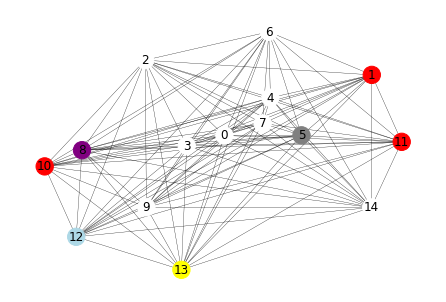

In [214]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.complete_graph(n_player)
for (u, v) in G.edges():
    G.edges[(u, v)]["weight"] = hatred_list[day-2][u][v]

assumption_role = {}
for i in range(n_player):
    for j in range(n_role):
        if role_values[j][i] == 1:
            assumption_role[i] = dic2[j]

color_map = []
for node in G:
    if true_role[node] == "WEREWOLF":
        color_map.append("red")
    elif true_role[node] == "POSSESSED":
        color_map.append("gray")
    elif true_role[node] == "SEER":
        color_map.append("lightblue")
    elif true_role[node] == "MEDIUM":
        color_map.append("purple")
    elif true_role[node] == "BODYGUARD":
        color_map.append("yellow")
    else:
        color_map.append("white")

nx.draw(G, node_color=color_map, with_labels=True, width=0.3)
print("true_role graph:")
plt.show()

実際の役職に関して赤が人狼, 灰色が狂人, 黄色が守護者, 水色が占い師, 紫色が霊媒師として相関関係が無向グラフで出力されています。